# Forecasting Retail Sales using Time Series Models.


DESCRIPTION:
The objective of this project is to develop a robust time series forecasting model that can accurately predict the unit sales for various items sold in Favorita stores. Favorita is a leading grocery retailer based in Ecuador, and the company's sales data will be used to build the model. The data set contains sales data for thousands of items sold at different stores, making it a challenging and complex problem.

To build an accurate forecasting model, various statistical and machine learning techniques will be used. The data will be preprocessed to ensure that it is clean, consistent, and in the right format for analysis. Exploratory data analysis (EDA) techniques will be employed to gain a deeper understanding of the data and identify any patterns or trends in the sales data.

Time series forecasting models, such as ARIMA, Linear regression and a few others will be used to predict store sales. These models will be trained using historical sales data, and their accuracy will be evaluated using various performance metrics such as root mean square logarithmic error, root mean squared error (RMSE), and mean square error (MSE).

The results obtained from the forecasting models will be analyzed, and insights gained from the analysis will be used to make informed business decisions. The insights could include identifying which products have high demand at different times of the year, which stores perform better than others, and identifying any trends in sales data that could inform marketing and inventory decisions.

Overall, the project aims to build a reliable time series forecasting model that can help Favorita optimize their sales strategies and improve their bottom line.

## Hypothesis

##### ALTENATE HYPOTHESIS: Average sales of a product family at a specific store is 500 

#####  ALTENATE HYPOTHESIS: Average sales of product family differ between store 1 and store 2 

##### ALTENATE Hypothesis: There is a significant difference in sales before and after promotion 

##### ALTENATE  Hypothesis: Promotion and sales outcomes are associated

##### ALTERNATE Hypothesis: The average sales of product family X differ between store Y1 and store Y2. 

## Questions

Is the train dataset complete (has all the required dates)?

Which dates have the lowest and highest sales for each year?

Did the earthquake impact sales?

Are certain groups of stores selling more products? (Cluster, city, state, type)

Are sales affected by promotions, oil prices and holidays?

What analysis can we get from the date and its extractable features?

What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)


### Data Importation
The project starts by importing necessary libraries and environment variables from the '.env' file. It then establishes a connection to the SQL Server using the provided credentials and loads data from three tables: 'dbo.oil', 'dbo.holidays_events', and 'dbo.stores'. Additionally, data from two local CSV files, 'sample_submission.csv' and 'test.csv', is imported using pandas. Lastly, data from a zip file, 'train.csv' and 'transactions.csv', is loaded into the DataFrame 'df_train' and 'df_transactions', respectively.

In [1]:
### Data importation
#pip install pyodbc
#pip install sqlalchemy
#pip install lightgbm
#pip install catboost
#pip install python-dotenv

In [5]:
# Libraries Importation
import pyodbc
import sqlalchemy as sa
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dotenv import dotenv_values
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

In [4]:
# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("database")
server = environment_variables.get("server")
username = environment_variables.get("username")
password = environment_variables.get("password")

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

conn = pyodbc.connect(connection_string)

In [5]:
#define the tables
table1 = 'dbo.oil'
table2 = 'dbo.holidays_events'
table3 = 'dbo.stores'

In [6]:
#creating  query to select the tables to be imported
query1 = f"SELECT * FROM {table1}"
df_oil = pd.read_sql(query1, conn)

query2 = f"SELECT * FROM {table2}"
df_holidays_events = pd.read_sql(query2, conn)

query3 = f"SELECT * FROM {table3}"
df_stores= pd.read_sql(query3, conn)

In [7]:
#close the connection
conn.close()

In [8]:
#importing local csv data
df_sample_submission=pd.read_csv('../Regression_Time_Series/Assets/sample_submission.csv')
df_test=pd.read_csv('../Regression_Time_Series/Assets/test.csv')

with zipfile.ZipFile('../Regression_Time_Series/Assets/trai&transactions.zip', 'r') as zip_ref:
    # Read the contents of the zip file
    with zip_ref.open('train.csv') as file_train:
        df_train = pd.read_csv(file_train)

    with zip_ref.open('transactions.csv') as file_transactions:
        df_transactions = pd.read_csv(file_transactions)


### Data Preparation

#### Oil Prices
The 'df_oil' DataFrame contains daily oil price data.
(Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)
The following data preparation steps are performed:

-Check for missing values, resulting in finding one missing value in the 'dcoilwtico' column.

-Fill the missing value using the forward-fill method to propagate the last valid observation forward.

-Convert the 'date' column to datetime format.
Extracted additional date features like 'year', 'month', 'day', and 'day_of_week'.

-Checked for duplicate rows and found none, so no duplicate rows were dropped.

-Checked for zero or negative oil prices and found none. No rows were removed or replaced.


In [9]:
df_oil


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
...,...,...
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999


In [10]:
# Check for missing values in df_oil
print(df_oil.isnull().sum())


date           0
dcoilwtico    43
dtype: int64


In [11]:
# Fill missing values using forward-fill method
df_oil.fillna(method='ffill', inplace=True)

# Verify if there are any missing values after filling
print(df_oil.isnull().sum())


date          0
dcoilwtico    1
dtype: int64


In [12]:

# Drop rows with missing values in 'dcoilwtico' column
df_oil.dropna(subset=['dcoilwtico'], inplace=True)

# Verify if there are any missing values after filling
print(df_oil.isnull().sum())



date          0
dcoilwtico    0
dtype: int64


In [13]:
# Convert 'date' column to datetime format
df_oil['date'] = pd.to_datetime(df_oil['date'])


In [14]:
# Extract additional date features
df_oil['year'] = df_oil['date'].dt.year
df_oil['month'] = df_oil['date'].dt.month
df_oil['day'] = df_oil['date'].dt.day
df_oil['day_of_week'] = df_oil['date'].dt.dayofweek


In [15]:
# Check data types of columns in df_oil
print(df_oil.dtypes)


date           datetime64[ns]
dcoilwtico            float64
year                    int64
month                   int64
day                     int64
day_of_week             int64
dtype: object


In [16]:
# Check for duplicate rows in df_oil
duplicate_rows = df_oil[df_oil.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

# Drop duplicate rows if needed
df_oil.drop_duplicates(inplace=True)


Number of duplicate rows: 0


In [17]:
# Check for zero or negative oil prices
invalid_prices = df_oil[df_oil['dcoilwtico'] <= 0]
print("Number of rows with zero or negative oil prices:", invalid_prices.shape[0])

# Replace or remove rows with zero or negative oil prices 

mean_oil_price = df_oil[df_oil['dcoilwtico'] > 0]['dcoilwtico'].mean()
df_oil.loc[df_oil['dcoilwtico'] <= 0, 'dcoilwtico'] = mean_oil_price


Number of rows with zero or negative oil prices: 0


In [18]:
# checking for seasonal decomposition using statsmodels library

# 'date' is set as the index of df_oil
result = seasonal_decompose(df_oil['dcoilwtico'], model='additive', period=365)
trend = result.trend
seasonal = result.seasonal
residual = result.resid



#### Holiday Events
The 'df_holidays_events' DataFrame contains holidays and events data

Check for missing values.
Convert the 'date' column to datetime format.
Extract additional date features like 'year', 'month', 'day', and 'day_of_week'.
Check for duplicate rows.
Handle any necessary cleaning or adjustments specific to this DataFrame.

In [19]:
df_holidays_events


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [20]:
# Check for missing values in df_holidays_events
print(df_holidays_events.isnull().sum())

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


In [21]:
# Convert 'date' column to datetime format
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])

In [22]:
# Extract additional date features
df_holidays_events['year'] = df_holidays_events['date'].dt.year
df_holidays_events['month'] = df_holidays_events['date'].dt.month
df_holidays_events['day'] = df_holidays_events['date'].dt.day
df_holidays_events['day_of_week'] = df_holidays_events['date'].dt.dayofweek

In [23]:
# Check for duplicate rows in df_holidays_events
duplicate_rows = df_holidays_events[df_holidays_events.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])


Number of duplicate rows: 0


In [24]:
# Filter holidays with 'type' as 'Transfer'
transfer_holidays = df_holidays_events[df_holidays_events['type'] == 'Transfer']

# Display the holidays with 'type' as 'Transfer'
print(transfer_holidays)


          date      type    locale locale_name  \
20  2012-10-12  Transfer  National     Ecuador   
73  2013-10-11  Transfer  National     Ecuador   
136 2014-10-10  Transfer  National     Ecuador   
256 2016-05-27  Transfer  National     Ecuador   
265 2016-07-24  Transfer     Local   Guayaquil   
269 2016-08-12  Transfer  National     Ecuador   
298 2017-01-02  Transfer  National     Ecuador   
304 2017-04-13  Transfer     Local      Cuenca   
313 2017-05-26  Transfer  National     Ecuador   
325 2017-08-11  Transfer  National     Ecuador   
329 2017-09-29  Transfer     Local      Ibarra   
342 2017-12-08  Transfer     Local       Quito   

                                description  transferred  year  month  day  \
20      Traslado Independencia de Guayaquil        False  2012     10   12   
73      Traslado Independencia de Guayaquil        False  2013     10   11   
136     Traslado Independencia de Guayaquil        False  2014     10   10   
256           Traslado Batalla de Pic

The code below defines a function 'handle_transferred_holidays' to adjust the holiday dates for transferred holidays. It checks if a holiday is transferred (True), then finds the corresponding row where the 'type' is 'Transfer' and the 'description' matches, and retrieves the transfer date. The adjusted date is then updated in the 'date' column. The 'transferred' column is dropped as it is no longer needed.

In [25]:
# Function to handle transferred holidays
def handle_transferred_holidays(row):
    if row['type'] == 'Transfer':
        corresponding_row = df_holidays_events[(df_holidays_events['description'] == row['description']) & 
                                               (df_holidays_events['type'] != 'Transfer') & 
                                               (df_holidays_events['date'] != row['date'])]
        if not corresponding_row.empty:
            return corresponding_row.iloc[0]['date']
    return row['date']

# Apply the function to update the date for transferred holidays
df_holidays_events['date'] = df_holidays_events.apply(handle_transferred_holidays, axis=1)

# Update the additional date features after handling transferred holidays
df_holidays_events['year'] = df_holidays_events['date'].dt.year
df_holidays_events['month'] = df_holidays_events['date'].dt.month
df_holidays_events['day'] = df_holidays_events['date'].dt.day
df_holidays_events['day_of_week'] = df_holidays_events['date'].dt.dayofweek

# Drop any duplicate rows created after handling transferred holidays
df_holidays_events.drop_duplicates(inplace=True)

# Print the first few rows of df_holidays_events after handling transferred holidays
print(df_holidays_events.head())


        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  year  month  day  day_of_week  
0        False  2012      3    2            4  
1        False  2012      4    1            6  
2        False  2012      4   12            3  
3        False  2012      4   14            5  
4        False  2012      4   21            5  


#### Stores

For data preparation on the df_stores DataFrame, we need to ensure that the data is cleaned, consistent, and in the right format for further analysis. 
Steps:
We will first check if there are any missing values in the DataFrame.
Ensure that the data types of columns are appropriate. For example, the 'cluster' column should be categorical, and the 'store_nbr' column should be an integer.
Remove any columns that are not needed for our analysis or modeling.
If there are any relevant features that can be extracted from existing columns, we will create them to help with analysis or modeling.

In [26]:
df_stores


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [27]:
# Check for Missing Values
print(df_stores.isnull().sum())

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


In [28]:
# Data Types
df_stores['type'] = df_stores['type'].astype('category')
df_stores['city'] = df_stores['city'].astype('category')
df_stores['state'] = df_stores['state'].astype('category')
df_stores['cluster'] = df_stores['cluster'].astype('category')

In [29]:
# Check for missing values in df_stores
print(df_stores.isnull().sum())


store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


In [30]:
# Verify the changes
print(df_stores.dtypes)

store_nbr       int64
city         category
state        category
type         category
cluster      category
dtype: object


#### Sample Submission
Since this is not part of the training data or directly used for modeling, there won't be any data preparation steps.


In [31]:
df_sample_submission


,version https://git-lfs.github.com/spec/v1
0,oid sha256:17505ec561d9bc64a3c10c3eb00474becf1...
1,size 342153


#### Transactions
Data preparation for the df_transactions DataFrame involves cleaning and organizing the transaction data before using it in the time series forecasting model. The df_transactions DataFrame contains information about transactions made on specific dates in various stores. 
Steps
-Check for Missing Values
-Convert 'date' Column to Datetime Format
-Extract Additional Date Features
-Check Data Types




In [32]:
df_transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [33]:
print(df_transactions.isnull().sum())


date            0
store_nbr       0
transactions    0
dtype: int64


In [34]:
df_transactions['date'] = pd.to_datetime(df_transactions['date'])


In [35]:
df_transactions['year'] = df_transactions['date'].dt.year
df_transactions['month'] = df_transactions['date'].dt.month
df_transactions['day'] = df_transactions['date'].dt.day
df_transactions['day_of_week'] = df_transactions['date'].dt.dayofweek


In [36]:
print(df_transactions.dtypes)


date            datetime64[ns]
store_nbr                int64
transactions             int64
year                     int64
month                    int64
day                      int64
day_of_week              int64
dtype: object


In [37]:
duplicate_rows = df_transactions[df_transactions.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

# Drop duplicate rows if needed
df_transactions.drop_duplicates(inplace=True)


Number of duplicate rows: 0


##### Train Data
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

In [38]:
df_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


#### Merging


In [39]:
# Check data types of 'date' column in both dataframes
print(df_train['date'].dtype)
print(df_holidays_events['date'].dtype)


object
datetime64[ns]


In [40]:
# Convert 'date' column to datetime data type in df_train
df_train['date'] = pd.to_datetime(df_train['date'])

# Now, let's try the merge again
df_train = df_train.merge(df_stores, on='store_nbr', how='left')
df_train = df_train.merge(df_holidays_events, on='date', how='left')
df_train = df_train.merge(df_oil, on='date', how='left')
df_train = df_train.merge(df_transactions, on=['date', 'store_nbr'], how='left')


In [41]:
#view merged data
merged_data = df_train

# Display the first few rows of the merged dataframe
print(merged_data.head())


   id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type_x cluster  ... dcoilwtico year_y month_y day_y day_of_week_y  \
0      D      13  ...        NaN    NaN     NaN   NaN           NaN   
1      D      13  ...        NaN    NaN     NaN   NaN           NaN   
2      D      13  ...        NaN    NaN     NaN   NaN           NaN   
3      D      13  ...        NaN    NaN     NaN   NaN           NaN   
4      D      13  ...        NaN    NaN     NaN   NaN           NaN   

   transactions  year  month  day  day_of_week  
0           NaN   NaN    NaN  NaN    

#### Handling Missing Data in Merged Data Frame
In the code below we handle our missing data after the merged.
Handling Missing Numeric Data:
For columns containing numeric data (e.g., oil prices), we leave NaN values as they are. Pandas handles NaN values in numeric columns appropriately during calculations.

Handling Missing Categorical Data:
For categorical columns (e.g., holiday events), we set a new category 'Not a Holiday' and fill the NaN values with this category. This ensures that the 'type_y' column includes all possible categories, even if they have missing values after the merge.

 -First, we add the 'Not a Holiday' category to the 'type_y' column.
 -Then, we fill the NaN values in the 'type_y' column with 'Not a Holiday'
 
Handling Missing Boolean Data:
For the "onpromotion" column, we fill NaN values with 0 to represent False (not on promotion). We treat the column as a boolean column, and missing values are considered as False.

Handling Missing Transaction Data:
For transaction data, we leave NaN values as they are. Since transaction data is numerical, Pandas handles missing values during calculations.

Dropping Duplicate Columns:
After merging the multiple datasets, we noticed there were duplicated columns with suffixes "_x" and "_y". We will remove these duplicate columns to avoid redundancy.
 


In [42]:
#Handling NaN values


# For numeric columns (e.g., oil prices), leave NaN values as they are.

# For categorical columns (e.g., holiday events), set the 'Not a Holiday' as a new category
# Convert 'type_y' column to 'category' data type
# Convert 'type_y' column to 'category' data type and add 'Not a Holiday' as a new category
#d

# Fill NaN values with 'Not a Holiday' to represent missing holiday events
df_train['type_y'].fillna('Not a Holiday', inplace=True)


# For the "onpromotion" column, fill NaN values with 0 to represent False (not on promotion)
df_train['onpromotion'].fillna(0, inplace=True)

# For transaction data, leave NaN values as they are.

# Now let's drop the duplicate columns (columns with suffixes _x and _y)
df_train.drop(df_train.filter(regex='_y$').columns, axis=1, inplace=True)

# Finally, let's check the dataframe to ensure it looks okay
print(df_train.head())

   id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type_x cluster  ...  year_x month_x day_x day_of_week_x  dcoilwtico  \
0      D      13  ...  2013.0     1.0   1.0           1.0         NaN   
1      D      13  ...  2013.0     1.0   1.0           1.0         NaN   
2      D      13  ...  2013.0     1.0   1.0           1.0         NaN   
3      D      13  ...  2013.0     1.0   1.0           1.0         NaN   
4      D      13  ...  2013.0     1.0   1.0           1.0         NaN   

   transactions  year  month  day  day_of_week  
0           NaN   NaN    

### Exploratory Data Analysis (EDA)

The next step in the project is to perform Exploratory Data Analysis (EDA) to gain insights into the data, understand its characteristics, and identify any patterns or trends that could influence the sales forecasting process. This will involve visualizations, summary statistics, and other analytical techniques to explore the data.

As part of EDA, we will:

Visualize the distribution of sales and other relevant variables.
Explore the relationship between sales and external factors like oil prices and holidays/events.
Analyze sales patterns over time, including seasonality and trends.
Examine correlations between different features to understand their interrelationships.
For example, we can plot sales over time to see if there are any recurring patterns, check if sales increase or decrease during specific months or years, and investigate whether there are any spikes in sales during holidays or promotions.

In [43]:
# Let's start by understanding the basic statistics and structure of the data.
print(df_train.head())
print(df_train.info())
print(df_train.describe())

   id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type_x cluster  ...  year_x month_x day_x day_of_week_x  dcoilwtico  \
0      D      13  ...  2013.0     1.0   1.0           1.0         NaN   
1      D      13  ...  2013.0     1.0   1.0           1.0         NaN   
2      D      13  ...  2013.0     1.0   1.0           1.0         NaN   
3      D      13  ...  2013.0     1.0   1.0           1.0         NaN   
4      D      13  ...  2013.0     1.0   1.0           1.0         NaN   

   transactions  year  month  day  day_of_week  
0           NaN   NaN    

#### Visualizing Data
We used various data visualization techniques to explore different aspects of the data.



##### To visualize the average sales for each store type.

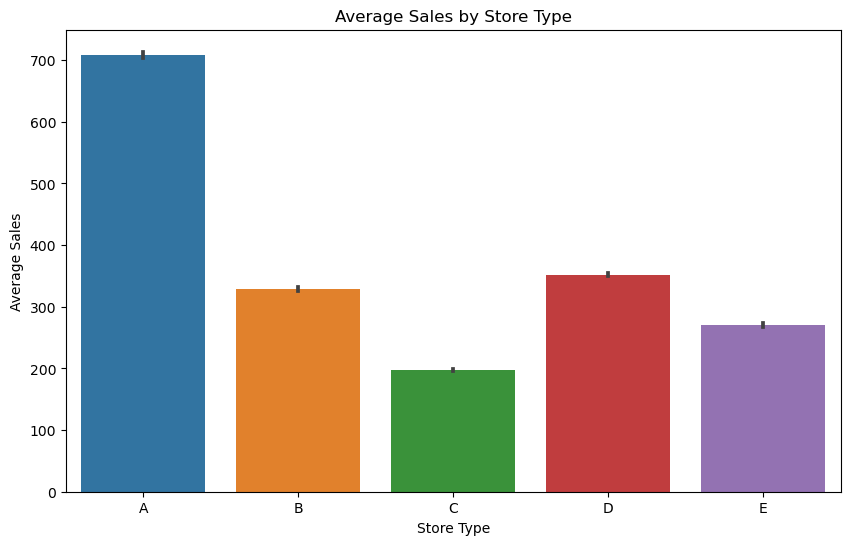

In [44]:
plt.figure(figsize=(10, 6))
sns.barplot(x='type_x', y='sales', data=df_train)
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.show()


From the bar plot, we can see that store type A has the highest average sales compared to the other store types in the dataset. This means that, on average, store type A performs better in terms of sales compared to store types B, C, and any other types that might be present in the dataset. It indicates that store type A is potentially the most successful or popular store type in Favorita.

##### To visualize the sales trend over time

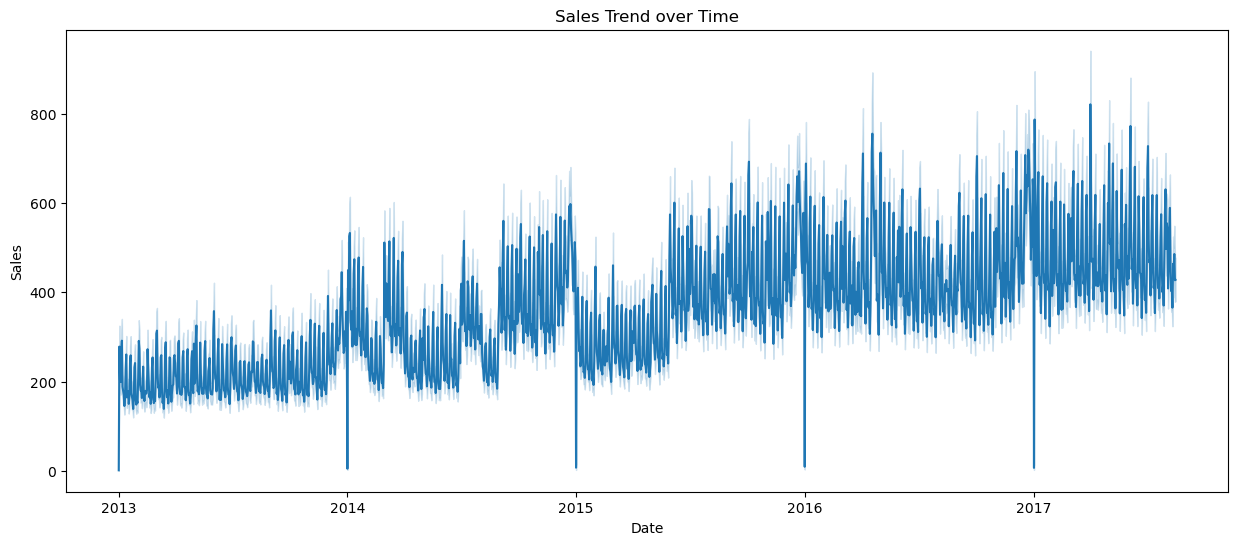

In [45]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='sales', data=df_train)
plt.title('Sales Trend over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


We can observe that there is a yearly seasonality in sales where data tend to increase at the beginning of each year and then decrease as the year progresses. This pattern suggests that there might be some seasonal factors influencing the sales behavior, and the sales trend repeats annually.

To further analyze the seasonality pattern and better understand the factors influencing the sales, we can perform seasonal decomposition or use advanced time series analysis techniques like SARIMA (Seasonal AutoRegressive Integrated Moving Average).

Seasonal decomposition can help break down the time series data into its constituent components, such as trend, seasonality, and residuals (random fluctuations). 

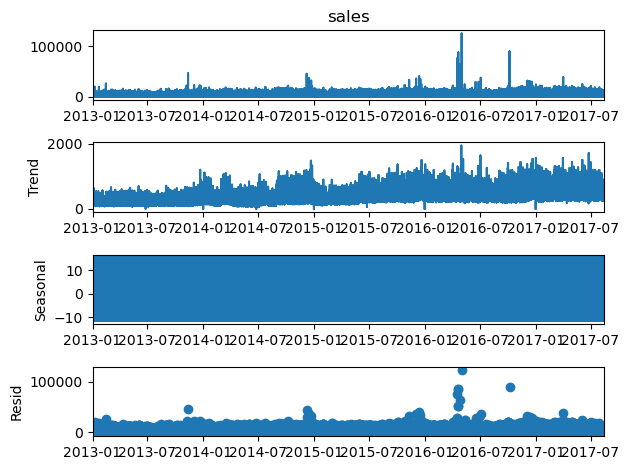

In [46]:
df_train.set_index('date', inplace=True)

# Perform seasonal decomposition
result = seasonal_decompose(df_train['sales'], model='additive', period=365)

# Plot the decomposed components
result.plot()
plt.show()


The SARIMA visualization reveals a generally upward trending pattern in sales over time, with occasional minor declines that do not significantly impact the overall trend. 
The fully colored seasonal component indicates prominent recurring patterns at fixed intervals, likely due to seasonal factors influencing sales. 
Additionally, the residual component shows mostly random behavior, but with a few outliers suggesting some patterns yet to be fully captured by the model.

##### To compare Sales on Holidays and Non Holidays

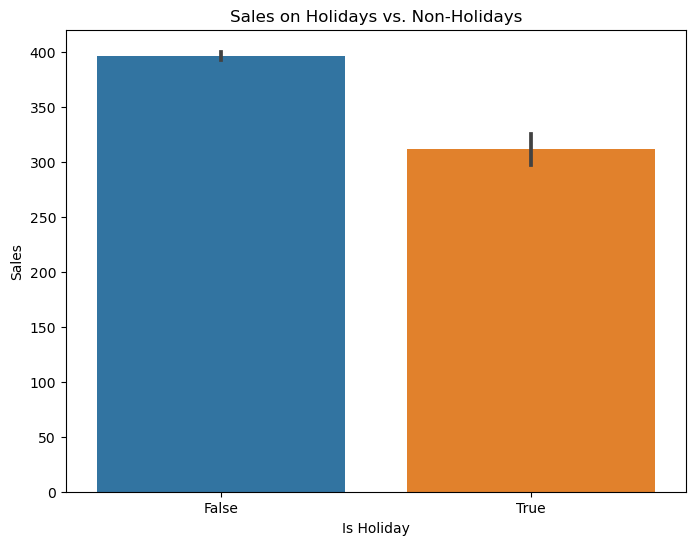

In [47]:
# Bar plot to compare sales on holidays and non-holidays
plt.figure(figsize=(8, 6))
sns.barplot(x='transferred', y='sales', data=df_train)
plt.title('Sales on Holidays vs. Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.show()



The bar plot comparing sales on holidays and non-holidays shows that sales are generally lower on holidays (transferred=True) compared to non-holidays (transferred=False). This suggests that there might be a negative impact on sales during holidays, possibly due to store closures or reduced consumer activity

##### Barplot to show Sales on Holidays By Store Type

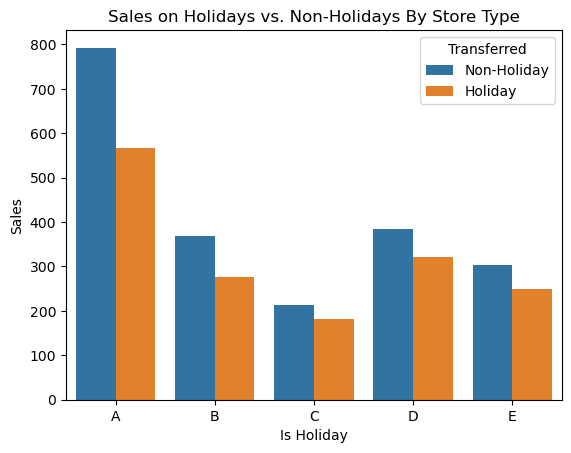

In [48]:
sns.barplot(x='type_x', y='sales', hue='transferred', data=df_train, ci=None)
plt.title('Sales on Holidays vs. Non-Holidays By Store Type')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.legend(title='Transferred', labels=['Non-Holiday', 'Holiday'])
plt.show()

The bar plot clearly illustrates that store type A exhibits the highest sales compared to the other store types in the dataset. This observation suggests that, store type A outperforms store types B, C, and any other potential types present in the dataset even on Holidays

##### Compare Sales with Oil prices

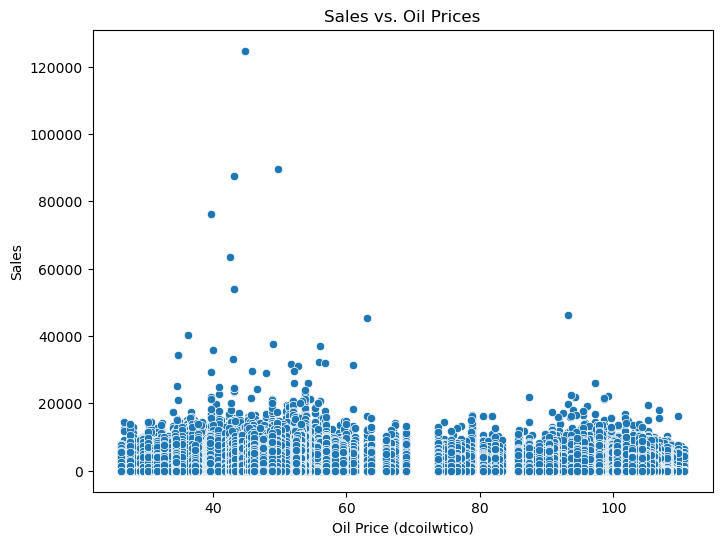

In [49]:
# Scatter plot to compare sales with oil prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dcoilwtico', y='sales', data=df_train)
plt.title('Sales vs. Oil Prices')
plt.xlabel('Oil Price (dcoilwtico)')
plt.ylabel('Sales')
plt.show()


From the scatter plot, we can observe the following:

Distribution: The majority of data points appear to be concentrated around a specific range of oil prices and sales values. 

Relationship: There is a positive relationship between sales and oil prices. As the oil price tends to increase, the sales also tend to increase slightly. However, the relationship is not very strong, as there is a scatter in the data points.

Outliers: There are a few outliers where the sales values are notably higher or lower than the majority of data points. These outliers could represent exceptional cases or specific events that might have influenced sales independently of oil prices.

Oil Price Range: Most of the data points have oil prices within a certain range, indicating that oil prices do not vary significantly across the dataset.

Sales Variation: Sales values vary widely across the dataset, regardless of oil prices. This suggests that there are other factors influencing sales beyond just oil prices.

Overall, the scatter plot helps us visualize the relationship between sales and oil prices. While there seems to be a weak positive association, it's essential to keep in mind that other factors may play a more significant role in influencing sales, and further analysis and modeling are needed to understand the complete picture.

##### Sales Variation with Store Clusters

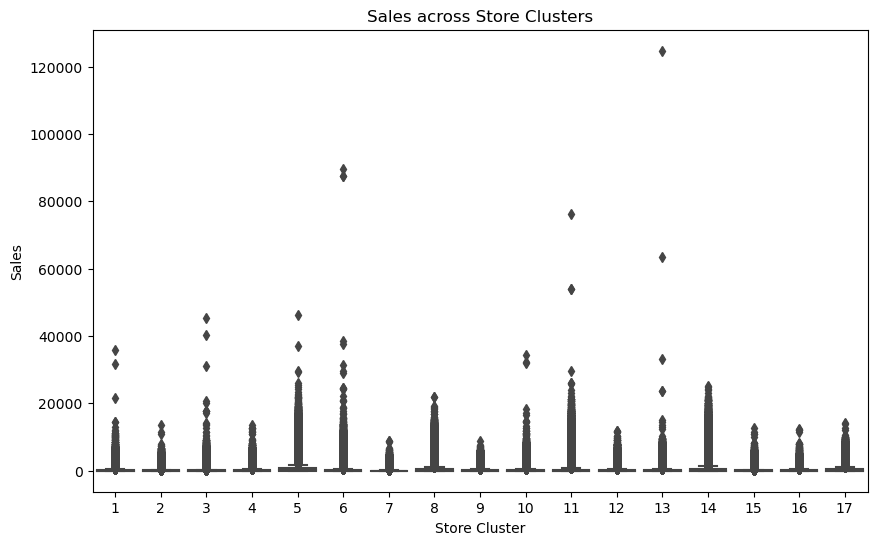

In [50]:
# Box plot to compare sales across store clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='sales', data=df_train)
plt.title('Sales across Store Clusters')
plt.xlabel('Store Cluster')
plt.ylabel('Sales')
plt.show()


The box plot provides a visual comparison of the sales distribution across different store clusters. It helps us understand the variation in sales between different groups of stores. Here are some key observations we can make from the box plot:

Cluster Comparison: By comparing the medians and IQRs of the boxes, we can identify clusters that tend to have higher or lower sales on average.

Outliers: Outliers indicate stores within a cluster that have exceptionally high or low sales compared to the majority of stores in that cluster.

Sales Range: The height of the boxes (IQR) and the length of the whiskers give us an idea of the range of sales values within each cluster.

Cluster Differences: The box plot allows us to identify clusters with significant differences in sales. Some clusters may have a more consistent sales performance, while others may have a wider variation in sales.

##### Sales Variation with Day of the Week
We can examine how sales vary with the day of the week. This can help us understand if there are any specific days when sales are higher or lower.

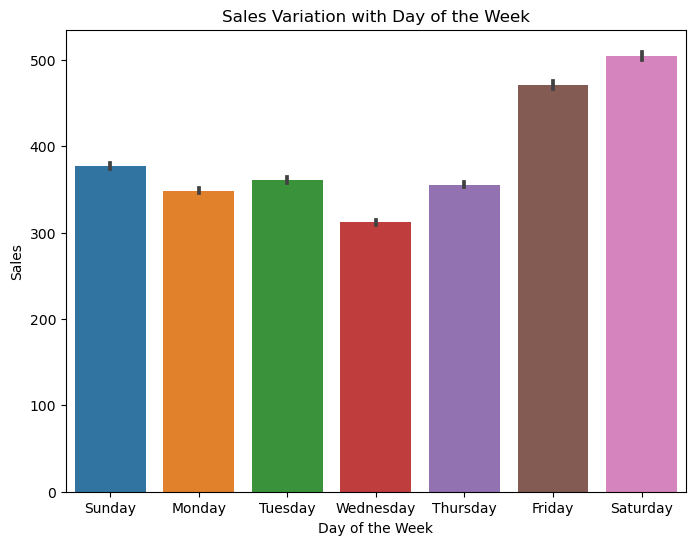

In [53]:
# Define the order of the days of the week
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Map the numeric day values to day names
day_mapping = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
df_train['day_of_week'] = df_train['day_of_week'].map(day_mapping)

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='day_of_week', y='sales', data=df_train, order=day_order)
plt.title('Sales Variation with Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.show()



The bar plot clearly illustrates that Saturday stands out with the highest average sales, whereas Wednesday shows the lowest average sales among all the days of the week. This crucial insight indicates that Saturdays are particularly successful or favored in terms of sales in the dataset, while Wednesdays experience comparatively lower sales activity. This

##### Sales Variation with On Promotion
We can analyze whether sales are significantly affected by promotional offers. A bar plot can show the average sales for items on promotion and not on promotion.

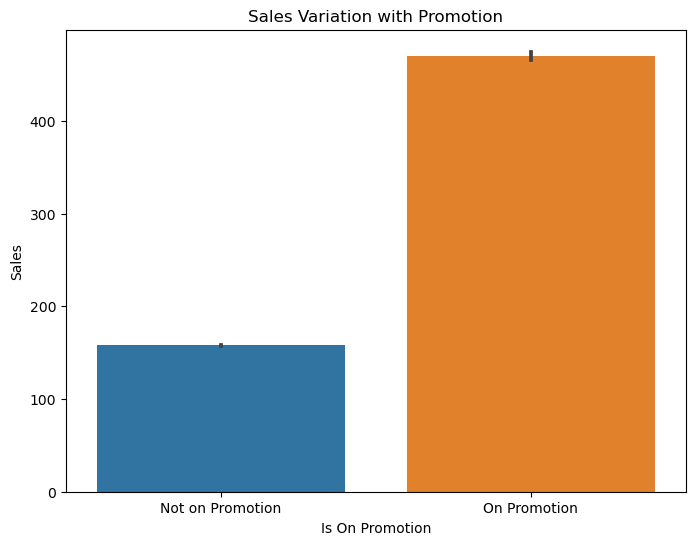

In [54]:
# Map the numeric onpromotion values to meaningful labels
onpromotion_mapping = {0: 'Not on Promotion', 1: 'On Promotion'}
df_train['onpromotion'] = df_train['onpromotion'].map(onpromotion_mapping)

# Create the bar plot with labels
plt.figure(figsize=(8, 6))
sns.barplot(x='onpromotion', y='sales', data=df_train)
plt.title('Sales Variation with Promotion')
plt.xlabel('Is On Promotion')
plt.ylabel('Sales')
plt.show()


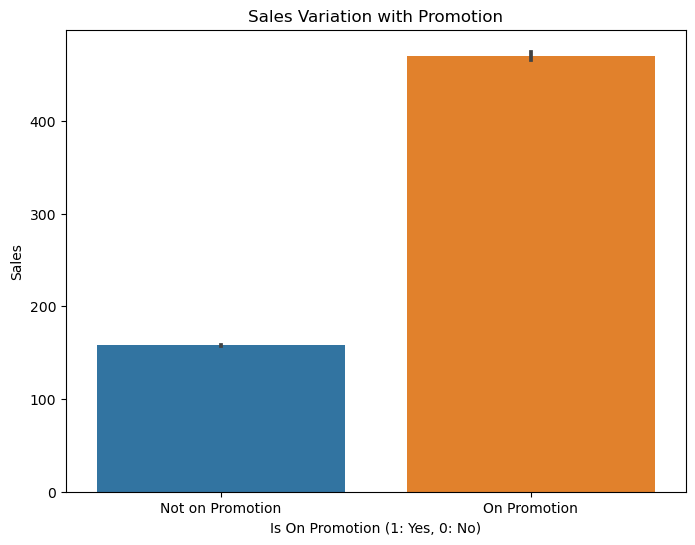

In [55]:
# Create the bar plot to compare sales variation with promotion
plt.figure(figsize=(8, 6))
sns.barplot(x='onpromotion', y='sales', data=df_train)

# Add title and labels for better understanding
plt.title('Sales Variation with Promotion')
plt.xlabel('Is On Promotion (1: Yes, 0: No)')  # Indicates that 1 represents "on promotion" and 0 represents "not on promotion"
plt.ylabel('Sales')

# Display the plot
plt.show()


From the bar plot, we can observe that sales for products that are on promotion are higher compared to products that are not on promotion. The bar corresponding to "On Promotion" is visibly taller than the one corresponding to "Not On Promotion," indicating that the average sales for products with promotions are greater.

### Hypothesis
1. One-Sample T-Test: If we have a specific hypothesis about the average sales of a product family at a particular store, we can use a one-sample t-test. For example, we could test whether the average sales of a product family at a specific store differ significantly from a certain value. 


2. Independent Samples T-Test: If we want to compare the average sales of a product family between two different stores, we can use an independent samples t-test. This test will help determine if there is a significant difference in the average sales of the product family between the two stores. 

 
3. Paired Samples T-Test: If we have data on sales for the same product family at a particular store on different dates, and we want to test if there is a significant difference in sales before and after a promotional period, we can use a paired samples t-test. 

 
4. Chi-Square Test: If we want to examine the relationship between the promotion of a product family (onpromotion column) and the sales outcomes (sales column), we can use a chi-square test. This test can help determine if there is a significant association between the two variables. 

 

These are just a few examples, and the choice of hypothesis test we can generate.  

  THESE ARE THE CODES ASSOCIATED WITH THE HYPOTHESIS WE DEVELOPED.  


#### One-Sample T-Test: is used to determine whether the mean of a sample significantly differs from a specified population mean.

#### NULL HYPOTHESIS :  Average sales of a product family at a specific store is not 500 

#### ALTENATE HYPOTHESIS: Average sales of a product family at a specific store is 500 

In [7]:
# sales_data =  Your sales data for the product family at the specific store 

sales_data = df_train.loc[(df_train['family'] == 'AUTOMOTIVE') & (df_train['store_nbr'] == 1), 'sales']


t_statistic, p_value = stats.ttest_1samp(sales_data, 500) 

 

if p_value < 0.05: 

    print("Reject null hypothesis: Average sales are significantly different from 500") 

else: 

    print("Fail to reject null hypothesis: Average sales are not significantly different from 500") 

 

#### Independent Samples T-Test: is utilized to compare the means of two independent groups to determine if they are significantly different from each other.

#### NULL HYPOTHESIS: Average sales of product family do not differ between store 1 and store 2


#### ALTENATE HYPOTHESIS: Average sales of product family differ between store 1 and store 2


In [ ]:
# Select the sales data for product family at store 1
sales_store1 = df_train.loc[(df_train['family'] == 'YOUR_PRODUCT_FAMILY') & (df_train['store_nbr'] == 1), 'sales']

# Select the sales data for product family at store 2
sales_store2 = df_train.loc[(df_train['family'] == 'YOUR_PRODUCT_FAMILY') & (df_train['store_nbr'] == 2), 'sales']

# Perform the independent samples t-test
t_statistic, p_value = stats.ttest_ind(sales_store1, sales_store2)

if p_value < 0.05:
    print("Reject null hypothesis: Average sales differ significantly between the stores")
else:
    print("Fail to reject null hypothesis: Average sales do not differ significantly between the stores")


#### Paired Samples T-Test: A paired samples t-test, also known as a dependent samples t-test, is employed to compare the means of two related groups or variables.

####  NULL HYPOTHESIS: There is no significant difference in sales before and after promotion

####  ALTENATE Hypothesis: There is a significant difference in sales before and after promotion

In [ ]:
# Select the sales data for product family before the promotion
sales_before = df_train.loc[(df_train['family'] == 'YOUR_PRODUCT_FAMILY') & (df_train['onpromotion'] == 0), 'sales']

# Select the sales data for product family after the promotion
sales_after = df_train.loc[(df_train.loc['family'] == 'YOUR_PRODUCT_FAMILY') & (df_train.loc['onpromotion'] == 1), 'sales']

# Perform the paired samples t-test
t_statistic, p_value = stats.ttest_rel(sales_before, sales_after)

if p_value < 0.05:
    print("Reject null hypothesis: There is a significant difference in sales before and after promotion")
else:
    print("Fail to reject null hypothesis: There is no significant difference in sales before and after promotion")


#### Chi-Square Test: is a statistical test that assesses the association between two categorical variables.

#### NULL HYPOTHESIS: Promotion and sales outcomes are not associated

#### ALTENATE  Hypothesis: Promotion and sales outcomes are associated

In [ ]:
# Select the promotion data for the product family
promotion_data = df_train.loc[df['family'] == 'YOUR_PRODUCT_FAMILY', 'onpromotion']

# Select the sales data for the product family
sales_data = df_train.loc[df['family'] == 'YOUR_PRODUCT_FAMILY', 'sales']

# Create a contingency table
contingency_table = [[sum(promotion_data), sum(sales_data)], [len(promotion_data) - sum(promotion_data), len(sales_data) - sum(sales_data)]]

# Perform the chi-square test of independence
chi2_statistic, p_value, _, _ = stats.chi2_contingency(contingency_table)

if p_value < 0.05:
    print("Reject null hypothesis: Promotion and sales outcomes are associated")
else:
    print("Fail to reject null hypothesis: Promotion and sales outcomes are not associated")

### QUESTIONS

#### 1. Which dates have the lowest and highest sales for each year?

In [ ]:
# # Convert the 'date' column to datetime format
# df['date'] = pd.to_datetime(df['date'])

# # Extract the year from the 'date' column
# df['year'] = df['date'].dt.year

# Group the data by year and find the dates with the lowest and highest sales for each year
lowest_sales_dates = df_train.groupby('year')['date'].min()
highest_sales_dates = df_train.groupby('year')['date'].max()

# Plot the lowest and highest sales dates for each year
plt.figure(figsize=(10, 6))
plt.plot(lowest_sales_dates.index, lowest_sales_dates, marker='o', label='Lowest Sales Date')
plt.plot(highest_sales_dates.index, highest_sales_dates, marker='o', label='Highest Sales Date')
plt.xlabel('Year')
plt.ylabel('Date')
plt.title('Dates with Lowest and Highest Sales for Each Year')
plt.legend()
plt.xticks(lowest_sales_dates.index)
plt.show()


#### 2. Are sales affected by promotions, oil prices and holidays?


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_train['date'], df_train['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.show()

#### 3. Did the earthquake impact sales?

In [ ]:
# Filter the data for the period after the earthquake
after_earthquake_df = df_train[df_train['date'] >= '2016-04-16']

# Visualize the impact of the earthquake on sales

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(after_earthquake_df['date'], after_earthquake_df['sales'])
plt.axvline(x='2016-04-16', color='red', linestyle='--', label='Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend After the Earthquake')
plt.legend()
plt.show()

#### 4. What analysis can we get from the date and its extractable features?

In [ ]:
# Time series plot
plt.figure(figsize=(10, 6))
plt.plot(df_train['date'], df['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.show()